<a href="https://colab.research.google.com/github/divyanshusharma1997/PortfolioProject/blob/main/Duplicate_quora_question_pair_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import warnings

warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
questions= pd.read_csv('/kaggle/input/question-pairs-dataset/questions.csv')

In [ ]:
new_df_0= questions[questions['is_duplicate']==0].sample(25000, random_state=5)
new_df_1= questions[questions['is_duplicate']==1].sample(25000, random_state=5)

In [ ]:
new_df= pd.concat([new_df_0,new_df_1], axis=0).sample(50000)

In [ ]:
new_df['is_duplicate'].value_counts()

1    25000
0    25000
Name: is_duplicate, dtype: int64

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


## preprocessing

In [ ]:
def preprocess(q):
    q= str(q).lower().strip()
    # replacing special character
    q= re.sub(r'\%', 'percent',q)
    q= re.sub(r'\&', 'and',q)
    q= re.sub(r'\$', 'dollar',q)
    q= re.sub(r'\₹', 'rupee',q)


    # replacing contracted words and removing stopwords
    contractions= {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    words= [contractions.get(word, word) for word in q.split()]



    # chat word/slang treatment
    abbreviations = {
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wbu" : "what about you",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
    }
    chat_clean= [abbreviations.get(short, short) for short in words]
    q= " ".join(chat_clean)

    #stemming
    ps= PorterStemmer()
    stem= [ps.stem(i) for i in q.split()]
    q= " ".join(stem)


    # removing emojis

    q= remove_emoji(q)

    #remove html tags
    q = re.sub(r"<.*?>", "", q)

    # remove punctuations
    q= re.sub(r'[^\w\s]',"",q)

    #spell check
    txtblb= TextBlob(q)
    q= txtblb.correct().string

        # updating numbers
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    return q

In [ ]:
text = "I! Haven't seen than asap wbu watshing trimming 13,000,000,000 sq  😀 $ <h1>"
preprocess(text)

'i have not seen than as soon as possible what about you watch trim 13b square  dollar '

In [ ]:
new_df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
72011,72011,61367,143113,"Did Einstein really define insanity as ""doing ...",How do I stop over thinking about things that ...,0
105110,105110,208489,208490,What are some things I should know about being...,What are some things I should know if I want t...,1
104074,104074,206443,206444,It is possible that one's hair does not grow a...,Is it possible that one's hair does not grow a...,1
305285,305285,599430,599431,Did British rule hinder or help the Indian eco...,What was the impact of British occupation in I...,1
179322,179322,354210,354211,Why is gravity constant?,Is gravity constant? Why or why not?,1


In [ ]:
# using multiple cores to make process faster
# for quesiton1 column
import joblib
from joblib import Parallel, delayed
data_chunks= new_df['question1']
preprocessed_chunks = Parallel(n_jobs=-1)(delayed(preprocess)(chunk) for chunk in data_chunks)
new_df['question1']=pd.Series(preprocessed_chunks, index= new_df.index)

In [ ]:
# for question2 column
data_chunks= new_df['question2']
preprocessed_chunks = Parallel(n_jobs=-1)(delayed(preprocess)(chunk) for chunk in data_chunks)
new_df['question2']=pd.Series(preprocessed_chunks, index= new_df.index)

In [ ]:
new_df

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,149218,149218,295203,295204,what is the differ between crime and felony an...,what is the differ between crime and felony,1
1,210783,210783,415757,415758,what do lawyer do,what is it like to be a lawyer at goose,0
2,278183,278183,546930,546931,how do i use good hangouts,how is good hangout use for a company,0
3,201120,201120,396883,396884,what are some mind wallet for safety that most...,what are some mindblow wallet tool that exist ...,1
4,268177,268177,527522,527523,what is artifice intelligence,factor involve in artifice intelligence,1
...,...,...,...,...,...,...,...
49995,368392,368392,720977,720978,what is the work profit of scientistengin pow...,can a color blind case gradual join iso as sci...,0
49996,249201,249201,490674,490675,what is cytosol in a cell,what is cytosol,0
49997,140050,140050,277230,277231,is the age rate slower in space,who do we age slower when travel at or near th...,1
49998,145789,145789,44885,288484,what is a good review paper or book on visual ...,is sport psychology fun,0


In [3]:
new_df.isnull().sum()

Unnamed: 0      0
id              0
qid1            0
qid2            0
question1       1
question2       1
is_duplicate    0
dtype: int64

In [4]:
new_df= new_df.dropna()

In [5]:
new_df= new_df.reset_index(drop= True)

In [6]:
new_df.duplicated().sum()

0

In [7]:
questions_df= new_df[['question1', 'question2']]

In [8]:
questions_df

,question1,question2
0,what is the differ between crime and felony an...,what is the differ between crime and felony
1,what do lawyer do,what is it like to be a lawyer at goose
2,how do i use good hangouts,how is good hangout use for a company
3,what are some mind wallet for safety that most...,what are some mindblow wallet tool that exist ...
4,what is artifice intelligence,factor involve in artifice intelligence
...,...,...
49993,what is the work profit of scientistengin pow...,can a color blind case gradual join iso as sci...
49994,what is cytosol in a cell,what is cytosol
49995,is the age rate slower in space,who do we age slower when travel at or near th...
49996,what is a good review paper or book on visual ...,is sport psychology fun


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
# countvectorizer need one dimentional array so we have to do this to make it 1 d
questions= list(new_df['question1'])+ list(new_df['question2'])

In [10]:
len(questions)

99996

In [ ]:
cv= CountVectorizer(max_features=3000, ngram_range=(1,3))
q1_array, q2_array= np.vsplit(cv.fit_transform(questions).toarray(), 2)

In [ ]:
tempdf1= pd.DataFrame(q1_array, index=new_df.index)
tempdf2= pd.DataFrame(q2_array, index=new_df.index)
temp_df= pd.concat([tempdf1, tempdf2], axis= 1)
temp_df

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
new_cols= [str(i) for i in range(1, temp_df.shape[1]+1)]
temp_df.columns = new_cols

In [ ]:
temp_df['is_duplicate']= new_df['is_duplicate']

In [ ]:
temp_df.head()

,1,2,3,4,5,6,7,8,9,10,...,5992,5993,5994,5995,5996,5997,5998,5999,6000,is_duplicate
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### approach 2

In [13]:
import gensim
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

[=================================================-] 99.6% 1656.8/1662.8MB downloaded


In [14]:
avg_data= []
for question in questions:
  vec= np.zeros(300)
  count= 0
  for word in gensim.utils.simple_preprocess(question):
    try:
      vec= vec+ model[word]
      count= count+1
    except:
      pass
  avg_data.append(vec/count)

In [15]:
q1_part, q2_part= avg_data[:49998], avg_data[49998:]

In [16]:
w2v_data= np.concatenate((q1_part,q2_part), axis=1)

In [18]:
w2v_df= pd.DataFrame(w2v_data, index=new_df.index)
w2v_df.columns= [str(i) for i in range(1,601)]
w2v_df

,1,2,3,4,5,6,7,8,9,10,...,591,592,593,594,595,596,597,598,599,600
0,0.052665,-0.038513,0.144243,0.017634,-0.115057,0.005460,0.096180,-0.078502,0.069991,0.020319,...,-0.066825,-0.053685,-0.005787,0.086321,-0.033552,-0.004647,0.021519,-0.137172,0.104353,-0.027448
1,0.088715,0.005398,0.056305,0.108765,-0.104248,0.079468,0.069336,-0.075821,0.088135,-0.059113,...,-0.063886,-0.000732,-0.068726,0.058800,-0.016262,0.050591,0.058273,-0.079071,0.066803,-0.044312
2,0.062305,0.054712,0.031128,0.182520,-0.164551,0.055090,0.062354,-0.062354,0.065259,0.051953,...,-0.027196,0.021423,-0.094343,0.047416,-0.004796,-0.005800,0.085013,-0.015599,0.016093,-0.003348
3,0.051624,-0.019505,0.076808,0.088715,-0.119991,0.029022,0.024166,-0.058630,0.103171,0.071259,...,-0.046204,0.004626,-0.049035,0.007540,-0.067049,0.003924,0.041098,-0.012333,0.068508,-0.046413
4,0.197868,-0.093216,0.061554,0.029121,-0.189453,0.145294,0.068970,-0.069763,0.073151,0.054260,...,-0.145654,0.105371,-0.018359,0.021777,-0.139111,-0.042920,0.045300,-0.091064,0.059509,0.050098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,0.054985,0.003946,0.055908,0.048981,-0.086639,-0.007284,0.065961,-0.158752,0.086933,0.084564,...,-0.046768,0.066757,-0.082214,0.015747,-0.030075,0.000443,-0.004264,0.004578,0.040062,0.061638
49994,-0.084332,0.046326,0.140430,-0.044116,-0.140039,0.014209,-0.068750,-0.169629,0.063477,0.042920,...,-0.202799,0.010986,-0.008626,-0.035645,-0.107178,0.071126,-0.090942,-0.046224,0.161133,-0.050334
49995,0.041709,0.075997,0.045183,0.115705,-0.070173,-0.042672,0.058384,-0.058158,0.134626,0.027178,...,-0.052127,0.012472,-0.089514,0.011626,-0.016266,-0.010238,0.002282,-0.021809,0.038496,-0.079102
49996,0.029717,-0.019010,0.063749,0.047321,-0.017249,0.046889,0.098778,-0.063364,0.055852,0.016836,...,-0.236176,0.120651,-0.181152,-0.008148,-0.056335,-0.073120,0.149445,-0.020264,0.080078,0.050293


## now we will apply some basic manual features that can help to improve our model results
## like question length, number of words, no. of common words, total number of unique word in both question, word share(common word/ total word)


In [ ]:
temp_df['len_q1']= new_df['question1'].str.len()
temp_df['len_q2']= new_df['question2'].str.len()


In [ ]:
# number of words
temp_df['num_words_q1']= new_df['question1'].apply(lambda x: len(x.split()))
temp_df['num_words_q2']= new_df['question2'].apply(lambda x: len(x.split()))

In [ ]:
# no of common words
def num_common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)
def num_total_unique_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1)+len(w2)


In [ ]:
temp_df['common_words']= new_df.apply(num_common_words, axis=1)

In [ ]:
temp_df['word_share']= round(temp_df['common_words']/new_df.apply(num_total_unique_words, axis= 1),2)

In [ ]:
temp_df

,1,2,3,4,5,6,7,8,9,10,...,5998,5999,6000,is_duplicate,len_q1,len_q2,num_words_q1,num_words_q2,common_words,word_share
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,70,43,13,8,8,0.40
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,17,39,4,10,2,0.15
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,26,37,6,8,3,0.21
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,87,80,17,15,11,0.35
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,29,39,4,5,2,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,92,60,15,10,1,0.04
49996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,25,15,6,3,3,0.33
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,31,71,7,16,5,0.22
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,75,23,14,4,3,0.17


In [ ]:
# <!-- now we will apply some advance features
# Advanced Features
# 1. Token Features
# cwc_min: This is the ratio of the number of common words to the length of the smaller question
# cwc_max: This is the ratio of the number of common words to the length of the larger question
# csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
# csc_max: This is the ratio of the number of common stop words to the larger stop word count among the two questions
# ctc_min: This is the ratio of the number of common tokens(not_repeatative) to the smaller token count among the two questions
# ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions
# last_word_eq: 1 if the last word in the two questions is same, 0 otherwise
# first_word_eq: 1 if the first word in the two questions is same, 0 otherwise
# 2. Length Based Features

# longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question
# 3. Fuzzy Features
# fuzz_ratio: fuzz_ratio score from fuzzywuzzy
# fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy
# token_sort_ratio: token_sort_ratio from fuzzywuzzy
# token_set_ratio: token_set_ratio from fuzzywuzzy -->

In [ ]:
!pip install distance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# get tokens
import distance
def get_token_features(row):

    SAFE_DIV = 0.0001
    q1= row['question1']
    q2= row['question2']

    q1_token= q1.split()
    q2_token= q2.split()

    token_feature= [0.0]*10
    stop_words = stopwords.words('english')
    if len(q1_token) == 0 or len(q2_token) == 0:
        return token_feature

    q1_words= [word for word in q1_token if word not in stop_words]
    q2_words= [word for word in q2_token if word not in stop_words]

    # cwc_min
    token_feature[0]= len(set(q1_token).intersection(set(q2_token)))/(min(len(q1_words), len(q2_words)) + SAFE_DIV)

    #cwc_max
    token_feature[1]= len(set(q1_token).intersection(set(q2_token)))/(max(len(q1_words), len(q2_words)) + SAFE_DIV)


    q1_stopwords= [word for word in q1_token if word in stop_words]

    q2_stopwords= [word for word in q2_token if word in stop_words]

    len_common_sw= len(set(q1_stopwords).intersection(set(q2_stopwords)))

    #csc_min
    token_feature[2]= len_common_sw/ (min(len(q1_stopwords), len(q2_stopwords)) + SAFE_DIV)

    #csc_max
    token_feature[3]= len_common_sw/ (max(len(q1_stopwords), len(q2_stopwords)) + SAFE_DIV)

    # now we will calculate common tokens with stopwods non repeatative
    common_token= len(set(q1_token).intersection(set(q2_token)))

    #ctc min
    token_feature[4]= common_token/ (min(len(set(q1_token)), len(set(q2_token))) + SAFE_DIV)

    #ctc max
    token_feature[5]= common_token/ (max(len(set(q1_token)), len(set(q2_token))) + SAFE_DIV)

    #last_word_eq
    token_feature[6]= int(q1_token[-1]==q2_token[-1])

    #first_word_eq
    token_feature[7]= int(q1_token[0]==q2_token[0])

    #longest common substrings and their ratio with smaller question
    long_comm_subs= list(distance.lcsubstrings(q1,q2))
    if len(long_comm_subs) > 0:
      token_feature[8]= len(long_comm_subs[0])/(min(len(q1_token), len(q2_token))+1)

    #longest common substrings and their ratio with bigger question

    long_comm_subs= list(distance.lcsubstrings(q1,q2))
    if len(long_comm_subs) > 0:
      token_feature[9]= len(long_comm_subs[0])/(max(len(q1_token), len(q2_token))+1)

    return token_feature

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
token_features= new_df.apply(get_token_features, axis=1)

In [ ]:
temp_df['cwc_min']= list(map(lambda x: x[0], token_features))
temp_df['cwc_max']= list(map(lambda x: x[1], token_features))
temp_df['csc_min']= list(map(lambda x: x[2], token_features))
temp_df['csc_max']= list(map(lambda x: x[3], token_features))
temp_df['ctc_min']= list(map(lambda x: x[4], token_features))
temp_df['ctc_max']= list(map(lambda x: x[5], token_features))
temp_df['is_last_word_eq']= list(map(lambda x: x[6], token_features))
temp_df['is_firstword_eq']= list(map(lambda x: x[7], token_features))
temp_df['long_substr_ratio_min']= list(map(lambda x: x[8], token_features))
temp_df['long_substr_ratio_max']= list(map(lambda x: x[9], token_features))

In [ ]:
temp_df

,1,2,3,4,5,6,7,8,9,10,...,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,is_last_word_eq,is_firstword_eq,long_substr_ratio_min,long_substr_ratio_max
0,0,0,0,0,0,0,0,0,0,0,...,2.666578,1.999950,0.999980,0.555549,0.999988,0.666661,0.0,1.0,4.777778,3.071429
1,0,0,0,0,0,0,0,0,0,0,...,1.999800,0.666644,0.333322,0.142855,0.666644,0.199998,0.0,1.0,1.600000,0.727273
2,0,0,0,0,0,0,0,0,0,0,...,0.999967,0.749981,0.333322,0.249994,0.499992,0.374995,0.0,1.0,1.857143,1.444444
3,0,0,0,0,0,0,0,0,0,0,...,2.199956,1.833303,0.888879,0.666661,0.785709,0.647055,0.0,1.0,2.187500,1.944444
4,0,0,0,0,0,0,0,0,0,0,...,0.999950,0.499988,0.000000,0.000000,0.499988,0.399992,1.0,0.0,4.400000,3.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0.142855,0.124998,0.000000,0.000000,0.099999,0.071428,0.0,0.0,1.363636,0.937500
49996,0,0,0,0,0,0,0,0,0,0,...,2.999700,1.499925,0.999950,0.499988,0.999967,0.499992,0.0,1.0,3.750000,2.142857
49997,0,0,0,0,0,0,0,0,0,0,...,1.249969,0.714276,0.666644,0.222220,0.714276,0.312498,1.0,0.0,1.125000,0.529412
49998,0,0,0,0,0,0,0,0,0,0,...,0.999967,0.374995,0.999900,0.166664,0.749981,0.214284,0.0,0.0,3.400000,1.133333


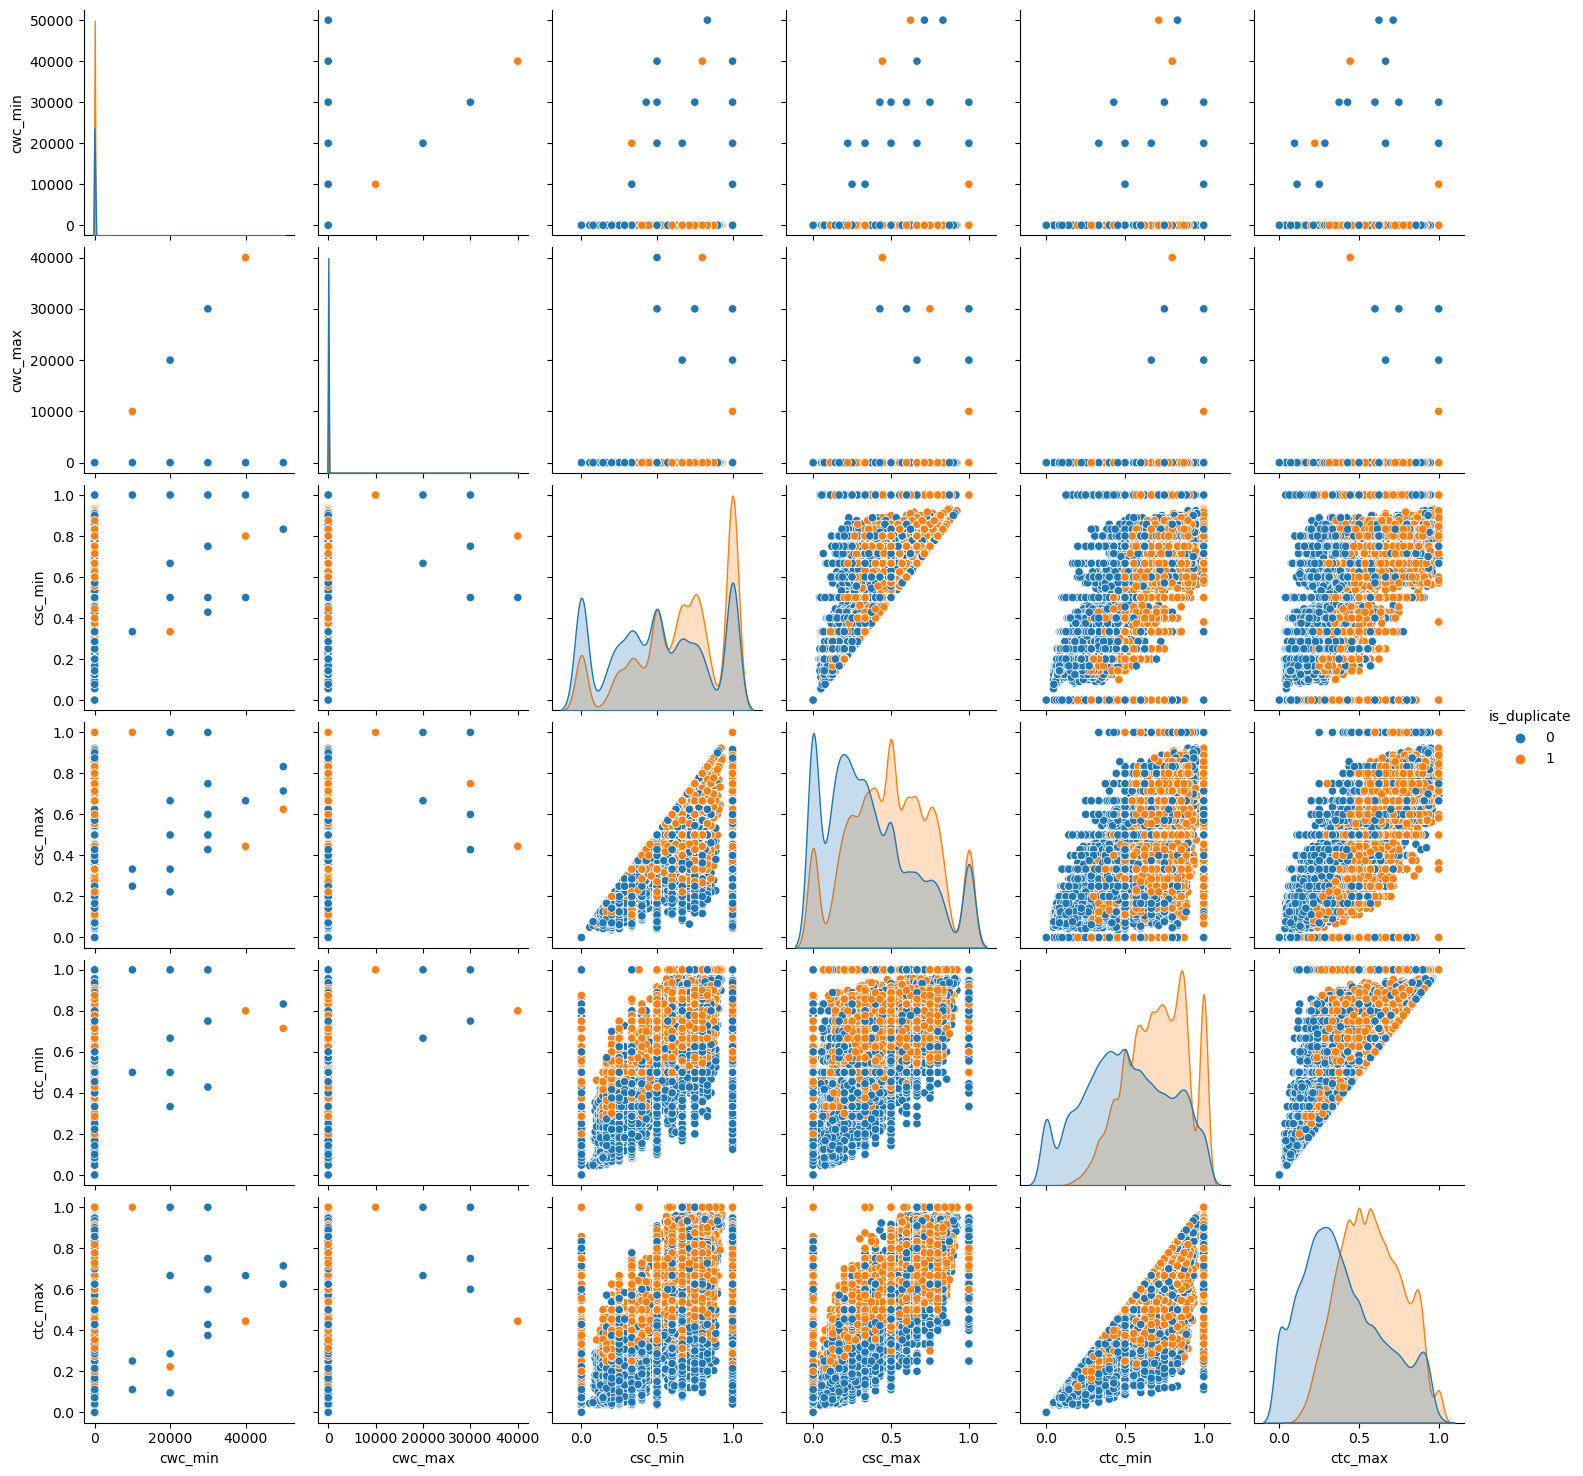

In [ ]:
sns.pairplot(temp_df[['cwc_min','cwc_max','csc_min', 'csc_max', 'ctc_min', 'ctc_max','is_duplicate']], hue= 'is_duplicate')

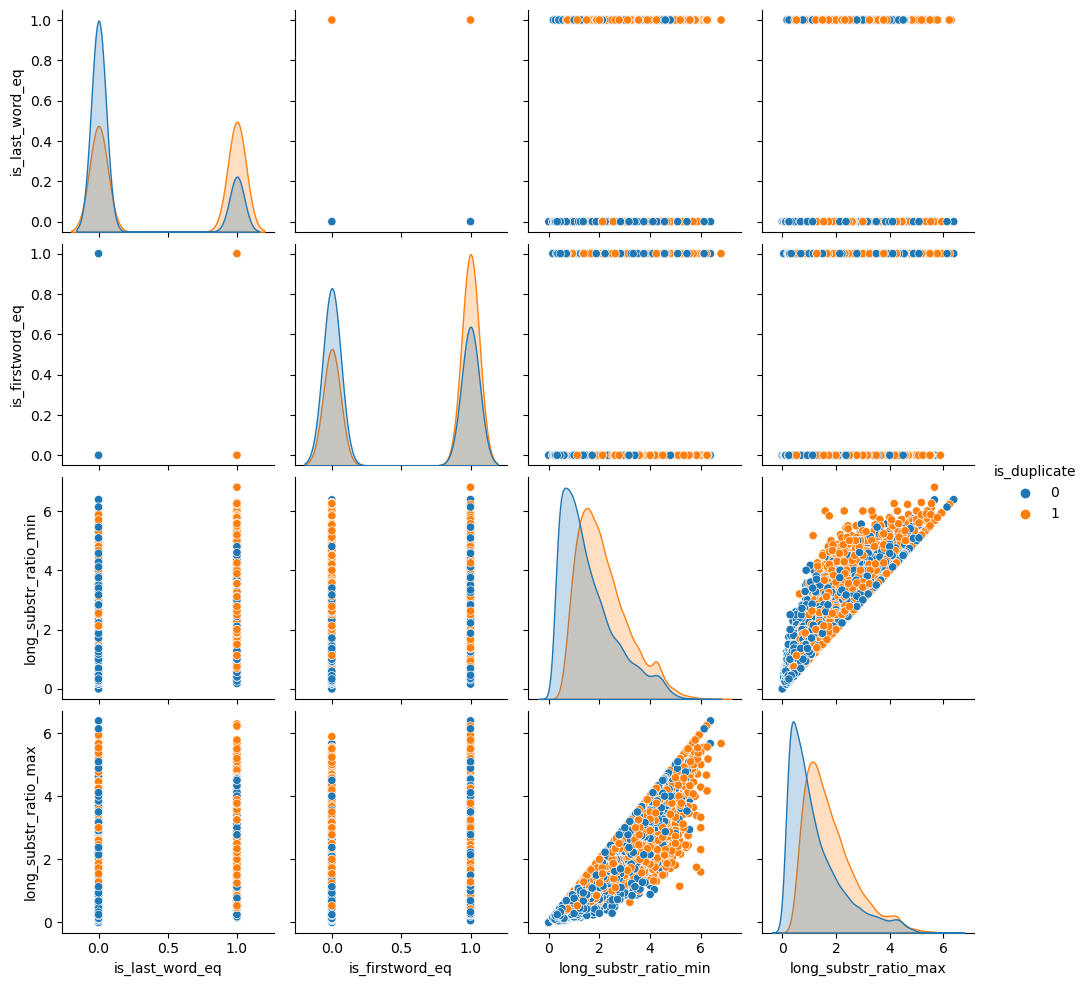

In [ ]:
sns.pairplot(temp_df[['is_last_word_eq','is_firstword_eq','long_substr_ratio_min','long_substr_ratio_max','is_duplicate']], hue= 'is_duplicate')

In [ ]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# fuzzy features from fuzzy wuzzy library
from fuzzywuzzy import fuzz
def fetch_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [ ]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
temp_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
temp_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
temp_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
temp_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [ ]:
temp_df

,1,2,3,4,5,6,7,8,9,10,...,ctc_min,ctc_max,is_last_word_eq,is_firstword_eq,long_substr_ratio_min,long_substr_ratio_max,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,0,0,0,0,0,0,0,0,0,...,0.999988,0.666661,0.0,1.0,4.777778,3.071429,76,100,76,100
1,0,0,0,0,0,0,0,0,0,0,...,0.666644,0.199998,0.0,1.0,1.600000,0.727273,54,59,50,88
2,0,0,0,0,0,0,0,0,0,0,...,0.499992,0.374995,0.0,1.0,1.857143,1.444444,63,77,76,76
3,0,0,0,0,0,0,0,0,0,0,...,0.785709,0.647055,0.0,1.0,2.187500,1.944444,78,78,74,85
4,0,0,0,0,0,0,0,0,0,0,...,0.499988,0.399992,1.0,0.0,4.400000,3.666667,76,83,68,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0.099999,0.071428,0.0,0.0,1.363636,0.937500,29,38,50,49
49996,0,0,0,0,0,0,0,0,0,0,...,0.999967,0.499992,0.0,1.0,3.750000,2.142857,75,100,75,100
49997,0,0,0,0,0,0,0,0,0,0,...,0.714276,0.312498,1.0,0.0,1.125000,0.529412,43,58,53,85
49998,0,0,0,0,0,0,0,0,0,0,...,0.749981,0.214284,0.0,0.0,3.400000,1.133333,39,86,43,90


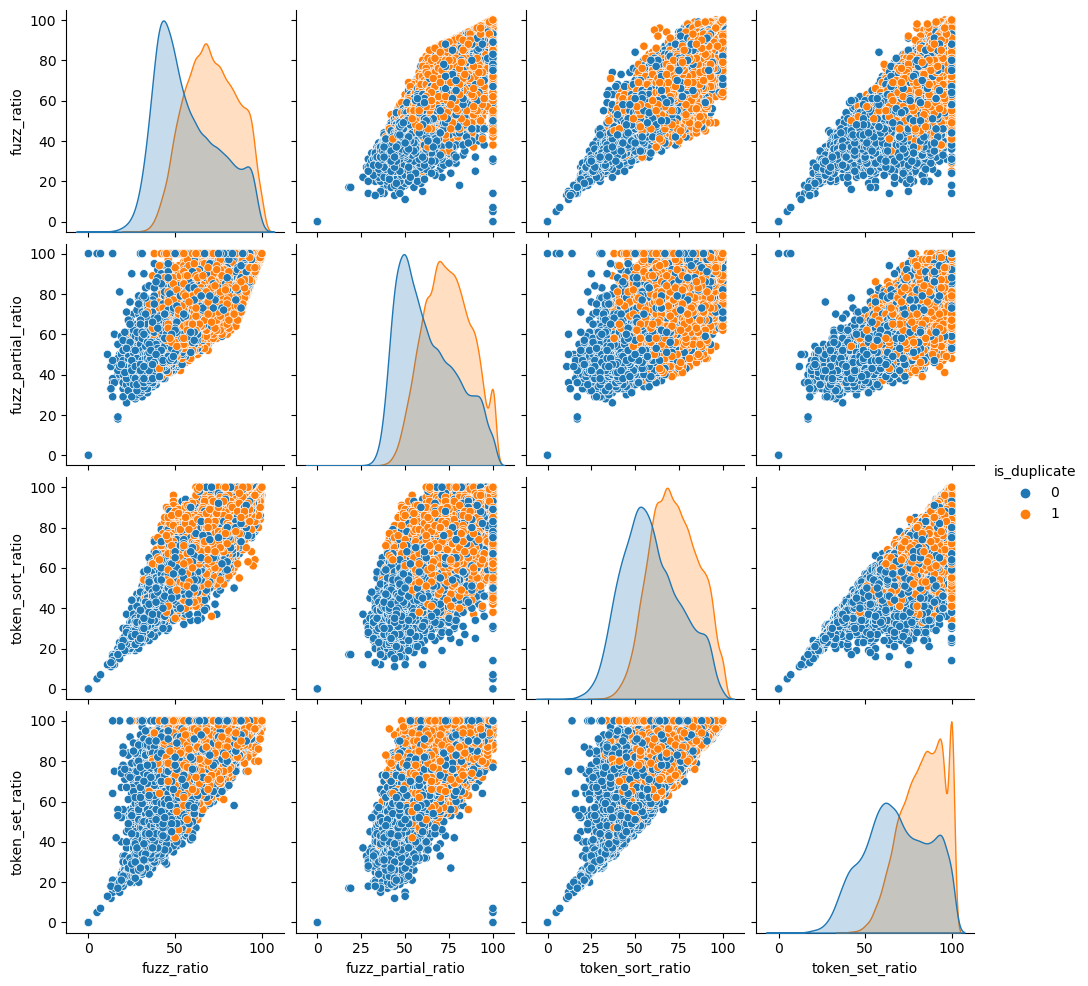

In [ ]:
sns.pairplot(temp_df[['fuzz_ratio','fuzz_partial_ratio','token_sort_ratio', 'token_set_ratio', 'is_duplicate']], hue= 'is_duplicate')

In [ ]:
w2v_df= pd.concat([w2v_df, temp_df.iloc[:,6000:]],axis=1)

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
# xtrain, xtest, ytrain, ytest= train_test_split(temp_df.drop("is_duplicate",axis=1), temp_df['is_duplicate'], test_size=0.2, random_state=42)
xtrain1,xtest1, ytrain1, ytest1= train_test_split(w2v_df.drop("is_duplicate",axis=1), w2v_df['is_duplicate'], test_size=0.2, random_state=23)

,1,2,3,4,5,6,7,8,9,10,...,ctc_min,ctc_max,is_last_word_eq,is_firstword_eq,long_substr_ratio_min,long_substr_ratio_max,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
2494,0.047863,0.003784,0.113892,0.013643,-0.042786,-0.040230,0.001953,-0.069611,0.072601,0.075301,...,0.999989,0.999989,1.0,1.0,3.800000,3.800000,100,100,100,100
30175,0.040628,0.028878,0.042768,0.002075,-0.216588,-0.008859,-0.002930,0.036307,0.063616,0.031285,...,0.571420,0.444440,0.0,1.0,2.375000,1.727273,52,69,57,68
36000,0.125664,0.048386,0.064133,0.006927,-0.067139,0.061768,0.049896,-0.140747,0.055115,0.018372,...,0.749981,0.499992,0.0,1.0,1.800000,1.285714,75,71,75,92
40208,0.041387,-0.011902,0.065656,0.057684,-0.040783,0.047430,0.019356,-0.016710,0.114530,0.071404,...,0.749991,0.428568,0.0,1.0,1.222222,0.733333,56,60,62,78
48194,0.073893,0.014689,-0.019084,0.060059,-0.160807,0.082357,0.014648,-0.095622,0.123535,0.014730,...,0.333328,0.249997,0.0,0.0,2.000000,1.400000,55,65,52,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29659,0.125781,0.035388,0.001953,0.096924,-0.253711,-0.044043,0.042554,-0.131079,0.004370,0.022266,...,0.599988,0.428565,0.0,0.0,2.333333,1.750000,51,58,59,68
36793,0.011861,0.025038,0.031318,0.131880,-0.124004,0.011393,0.055586,-0.054114,0.041679,0.055058,...,0.000000,0.000000,0.0,0.0,0.375000,0.150000,22,44,25,26
12974,-0.005314,0.016763,0.059937,0.097911,-0.050511,-0.029021,0.015004,-0.101281,0.061871,0.103131,...,0.249997,0.083333,0.0,0.0,0.400000,0.133333,16,38,21,23
20194,0.082031,0.004542,0.099182,0.149094,-0.119629,-0.002808,0.055298,-0.061699,0.081285,0.081543,...,0.777769,0.499996,0.0,1.0,2.000000,1.250000,59,84,64,90


In [ ]:
#testin first approach with bag of words

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [ ]:
rf= RandomForestClassifier(n_jobs=-1)
rf.fit(xtrain, ytrain)
accuracy_score(ytest, rf.predict(xtest))

0.7865

In [ ]:
confusion_matrix(ytest, rf.predict(xtest))

array([[3553, 1425],
       [ 710, 4312]])

In [ ]:
print(classification_report(ytest,rf.predict(xtest)))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77      4978
           1       0.75      0.86      0.80      5022

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



In [ ]:
temp_df

,1,2,3,4,5,6,7,8,9,10,...,ctc_min,ctc_max,is_last_word_eq,is_firstword_eq,long_substr_ratio_min,long_substr_ratio_max,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
149218,0,0,0,0,0,0,0,0,0,0,...,0.999988,0.666661,0.0,1.0,4.777778,3.071429,76,100,76,100
210783,0,0,0,0,0,0,0,0,0,0,...,0.666644,0.199998,0.0,1.0,1.600000,0.727273,54,59,50,88
278183,0,0,0,0,0,0,0,0,0,0,...,0.499992,0.374995,0.0,1.0,1.857143,1.444444,63,77,76,76
201120,0,0,0,0,0,0,0,0,0,0,...,0.785709,0.647055,0.0,1.0,2.187500,1.944444,79,82,74,85
268177,0,0,0,0,0,0,0,0,0,0,...,0.499988,0.399992,1.0,0.0,4.400000,3.666667,76,83,68,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368392,0,0,0,0,0,0,0,0,0,0,...,0.099999,0.071428,0.0,0.0,1.363636,0.937500,39,50,50,51
249201,0,0,0,0,0,0,0,0,0,0,...,0.999967,0.499992,0.0,1.0,3.750000,2.142857,75,100,75,100
140050,0,0,0,0,0,0,0,0,0,0,...,0.714276,0.312498,1.0,0.0,1.125000,0.529412,47,58,53,85
145789,0,0,0,0,0,0,0,0,0,0,...,0.749981,0.214284,0.0,0.0,3.400000,1.133333,39,86,43,90


In [ ]:
xgb = XGBClassifier(n_jobs=-1)
xgb.fit(xtrain,ytrain)
ypred = xgb.predict(xtest)
accuracy_score(ytest,ypred)

0.7816

In [ ]:
print(classification_report(ytest,xgb.predict(xtest)))

              precision    recall  f1-score   support

           0       0.83      0.71      0.76      4978
           1       0.75      0.85      0.80      5022

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



In [ ]:
confusion_matrix(ytest, xgb.predict(xtest))

array([[3530, 1448],
       [ 736, 4286]])

In [ ]:
NB= GaussianNB()
NB.fit(xtrain, ytrain)
accuracy_score(ytest, NB.predict(xtest))

0.6722

In [ ]:
#applying approach 2 with word 2 vec

In [29]:
xgb1= XGBClassifier(n_jobs=-1)
xgb1.fit(xtrain1, ytrain1)
accuracy_score(ytest1,xgb1.predict(xtest1))

0.7754775477547755

In [27]:
rf1= RandomForestClassifier(n_jobs=-1)
rf1.fit(xtrain1, ytrain1)
accuracy_score(ytest1,rf1.predict(xtest1))

0.7575757575757576

In [30]:
NB1= GaussianNB()
NB1.fit(xtrain1, ytrain1)
accuracy_score(ytest1, NB1.predict(xtest1))

0.6853685368536854

In [32]:
print("random forest: \n",classification_report(ytest1,rf1.predict(xtest1)))
print("xgboost: \n",classification_report(ytest1,xgb1.predict(xtest1)))

random forest: 
               precision    recall  f1-score   support

           0       0.82      0.66      0.73      5034
           1       0.71      0.86      0.78      4965

    accuracy                           0.76      9999
   macro avg       0.77      0.76      0.76      9999
weighted avg       0.77      0.76      0.76      9999

xgboost: 
               precision    recall  f1-score   support

           0       0.81      0.72      0.76      5034
           1       0.75      0.83      0.79      4965

    accuracy                           0.78      9999
   macro avg       0.78      0.78      0.77      9999
weighted avg       0.78      0.78      0.77      9999



In [33]:
# in random forest model we have lesser false positives which is more important for our problem
# here Bag of word approach is working better than word2vec so we will use that

In [ ]:
def query_point(q1, q2):
    #preprocessing
    q1= preprocess(q1)
    q2= preprocess(q2)
    tempdict= {
        'question1': q1,
        'question2': q2
    }
    tempodf= pd.DataFrame(tempdict, index= [1])
    bow_q1= cv.transform([q1]).toarray()
    bow_q2= cv.transform([q2]).toarray()

    fq= []
    #basic features
    fq.append(len(q1))
    fq.append(len(q2))
    fq.append(len(q1.split()))
    fq.append(len(q2.split()))
    fq.append(num_common_words(tempodf.iloc[0]))
    fq.append(num_common_words(tempodf.iloc[0])/num_total_unique_words(tempodf.iloc[0]))
    # token featrures
    fq.extend(get_token_features(tempodf.iloc[0]))
    # fuzzy features
    fq.extend(fetch_fuzzy_features(tempodf.iloc[0]))
    fq = np.array(fq).reshape(1, -1)
    return np.hstack((bow_q1, bow_q2, fq))

In [ ]:
import pickle

pickle.dump(rf,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))